In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
data = pd.read_csv("Cardiovascular_Disease_Dataset.csv")
data.rename(columns={'gender': 'male'}, inplace=True)
print(data["restingBP"].min())
print(data["restingBP"].max())
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
data.drop(columns=["patientid"], axis=1, inplace=True)
print(data["male"].value_counts())
print(data["target"].value_counts())
print(data["target"][data["male"]==0].value_counts())
data['chestpain'] = data['chestpain'].apply(lambda x: 1 if x > 0 else 0)
X = data.drop(['target', 'serumcholestrol', 'fastingbloodsugar', 'restingrelectro', 'oldpeak', 'slope', 'noofmajorvessels'], axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X

94
200
male
1    765
0    235
Name: count, dtype: int64
target
1    580
0    420
Name: count, dtype: int64
target
1    133
0    102
Name: count, dtype: int64


,age,male,chestpain,restingBP,maxheartrate,exerciseangia
0,53,1,1,171,147,0
1,40,1,0,94,115,0
2,49,1,1,133,202,1
3,43,1,0,138,153,0
4,31,1,1,199,136,0
...,...,...,...,...,...,...
995,48,1,1,139,183,1
996,47,1,1,143,98,1
997,69,1,0,156,196,0
998,45,1,1,186,117,1


In [22]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

def create_xgboost_model(learning_rate=0.1, max_depth=2, n_estimators=129):
    model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
    return model
xgboost_model = create_xgboost_model()
xgboost_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=129, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

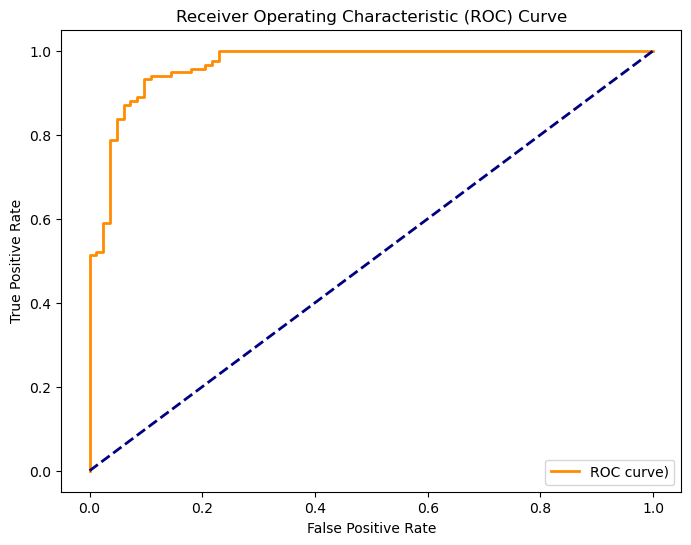

Cross-Validation Scores: [0.8875  0.875   0.9     0.86875 0.91875]
Mean Accuracy: 0.8900

Accuracy on Test Set: 0.9200
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90        83
           1       0.92      0.94      0.93       117

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


#mean values
#data["serumcholestrol"] = 311.447
#data["fastingbloodsugar"] = 0.296
#data["restingrelectro"] = 0.748
#data["oldpeak"] = 2.7077
#data["slope"] = 1.54
#data["noofmajorvessels"] = 1.222

X = data.drop(['target', 'serumcholestrol', 'fastingbloodsugar', 'restingrelectro', 'oldpeak', 'slope', 'noofmajorvessels'], axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fpr, tpr, thresholds = roc_curve(y_test, xgboost_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve)'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=35)
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=cv, scoring=make_scorer(accuracy_score))
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy: {:.4f}".format(cv_scores.mean()))
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"\nAccuracy on Test Set: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)